# Tok v síti — formulace jako lineární program (LP), řešení a vizualizace

**Cíl.** Najít maximální přenosovou rychlost z počítače `s` do počítače `n` v dané síti.  
Čísla u propojení znamenají *kapacitu* (např. MB/s). Každé propojení lze použít v jednom směru,
ale proměnnou pro každé spojení povedeme s **povolenými zápornými hodnotami**. Záporné číslo znamená,
že tok teče opačným směrem. Tímto jednou proměnnou pokryjeme „obousměrnost bez současného směru“.

## Uzly a hrany
Uzly: `s` (zdroj), prostřední `a,b,c,d,e`, `n` (cílový).  
Hrany s kapacitami (z leva doprava):  
`(s,a):3, (s,b):1, (s,c):1, (a,b):1, (a,d):1, (b,e):3, (c,d):4, (c,e):4, (d,n):4, (e,n):1`.

## Proměnné
Pro každou uvedenou hranu `(u,v)` zavádíme proměnnou `x_uv` s omezením `-cap ≤ x_uv ≤ cap`.
Kladné `x_uv` = tok teče z `u` do `v`, záporné `x_uv` = tok teče z `v` do `u`.

## Toková bilance
Pro vnitřní uzly vyžadujeme, aby tok, který do uzlu přiteče, z něj také odtekl:
- `a`: `x_sa = x_ab + x_ad`
- `b`: `x_sb + x_ab = x_be`
- `c`: `x_sc = x_cd + x_ce`
- `d`: `x_ad + x_cd = x_dn`
- `e`: `x_be + x_ce = x_en`

## Účelová funkce
Maximalizujeme `x_sa + x_sb + x_sc`, tj. celkový tok opouštějící `s`
(rovná se také `x_dn + x_en`, tj. celkový tok přitékající do `n`).

Výstupem bude optimální hodnota toku a konkrétní směry/velikosti na hranách.
Součástí je i obrázek sítě s vyznačenými průtoky a informací, které hrany jsou saturované.

# Instalace a importy

In [4]:
# Instalace a importy
!pip -q install pulp networkx matplotlib numpy pandas

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pulp

plt.rcParams["figure.figsize"] = (7.5, 5.5)
plt.rcParams["axes.grid"] = True


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 103.8 MB/s eta 0:00:00


# Data sítě

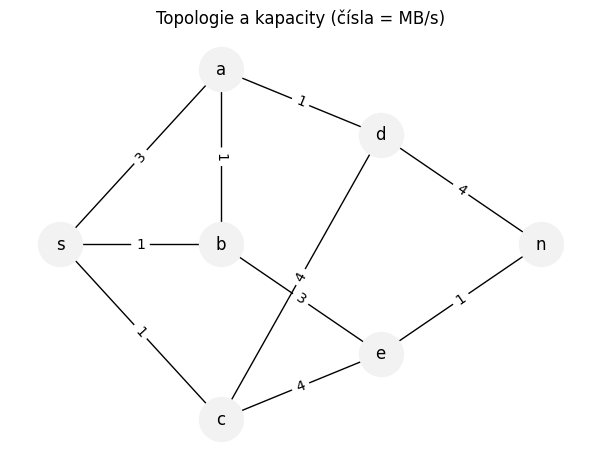

In [5]:
# Definice uzlů a kapacit z učebnicového příkladu
nodes = ["s","a","b","c","d","e","n"]
# Směry zapisujeme zleva doprava; záporná hodnota proměnné dovolí tok opačně
caps = {
    ("s","a"):3,
    ("s","b"):1,
    ("s","c"):1,
    ("a","b"):1,
    ("a","d"):1,
    ("b","e"):3,
    ("c","d"):4,
    ("c","e"):4,
    ("d","n"):4,
    ("e","n"):1,
}

# Fixní pozice pro přehlednou kresbu
pos = {
    "s":(-1.2, 0.0),
    "a":( 0.0, 0.8),
    "b":( 0.0, 0.0),
    "c":( 0.0,-0.8),
    "d":( 1.2, 0.5),
    "e":( 1.2,-0.5),
    "n":( 2.4, 0.0),
}

# Pomocná funkce: kresba kapacit (bez směrů toku)
def draw_capacities(caps, title="Síť a kapacity"):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for (u,v),cap in caps.items():
        G.add_edge(u,v,cap=cap)
    fig, ax = plt.subplots()
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="#f2f2f2", ax=ax)
    # Popisky kapacit u hran
    edge_labels = {(u,v): str(data["cap"]) for u,v,data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)
    ax.set_title(title)
    plt.show()

draw_capacities(caps, "Topologie a kapacity (čísla = MB/s)")


# Formulace LP v PuLP a řešení

In [6]:
# Obecná LP formulace s jednou proměnnou na hranu a zápornými hodnotami pro opačný směr

def solve_maxflow_lp(nodes, caps, source="s", sink="n", msg=False):
    edges = list(caps.keys())
    prob = pulp.LpProblem("MaxFlowLP", pulp.LpMaximize)

    x = {(u,v): pulp.LpVariable(f"x_{u}{v}", lowBound=-caps[(u,v)], upBound=caps[(u,v)]) for (u,v) in edges}
    prob += pulp.lpSum(x[(u,v)] for (u,v) in edges if u == source), "total_flow"

    inner_nodes = [k for k in nodes if k not in (source, sink)]
    for k in inner_nodes:
        out_edges = [(u,v) for (u,v) in edges if u == k]
        in_edges  = [(u,v) for (u,v) in edges if v == k]
        prob += pulp.lpSum(x[e] for e in out_edges) - pulp.lpSum(x[e] for e in in_edges) == 0, f"balance_{k}"

    status_code = prob.solve(pulp.PULP_CBC_CMD(msg=msg))
    status = pulp.LpStatus[status_code]
    F = pulp.value(prob.objective)  # může být None
    flows = {e: (x[e].value() if x[e].value() is not None else 0.0) for e in edges}
    return prob, status, (0.0 if F is None else F), flows

prob, status, F, flows = solve_maxflow_lp(nodes, caps, source="s", sink="n", msg=False)

print("Stav řešení:", status)
print("Maximální tok:", F)

pd.DataFrame(
    [(f"{u}->{v}", f"{flows[(u,v)]:.3f}", caps[(u,v)]) for (u,v) in caps],
    columns=["hrana","tok x_uv","kapacita"]
)


Stav řešení: Optimal
Maximální tok: 4.0


hrana tok x_uv  kapacita
0  s->a    2.000         3
1  s->b    1.000         1
2  s->c    1.000         1
3  a->b    1.000         1
4  a->d    1.000         1
5  b->e    2.000         3
6  c->d    3.000         4
7  c->e   -2.000         4
8  d->n    4.000         4
9  e->n    0.000         1

# Vizualizace nalezeného toku a diagnostika

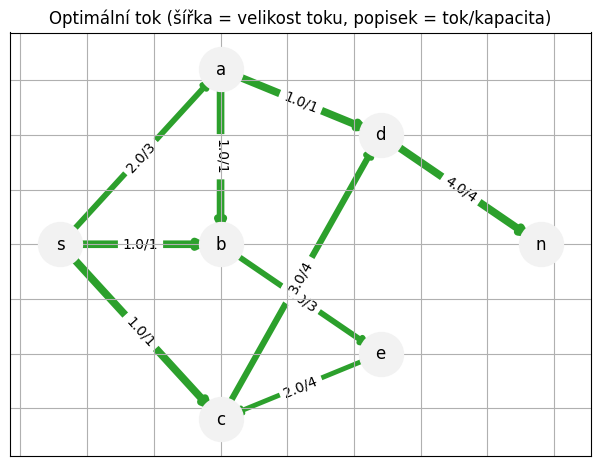

Saturované hrany (|tok| = kapacita):
  s-b: |1.000| = 1
  s-c: |1.000| = 1
  a-b: |1.000| = 1
  a-d: |1.000| = 1
  d-n: |4.000| = 4

Hrany s opačným směrem toku (x_uv < 0):
  c<->e: x_ce = -2.000 (teče e→c)


In [7]:
# Vizualizace toku: šipka v reálném směru, šířka ∝ |tok|, barva zelená (kladný) / červená (záporný)
def draw_flow(caps, flows, title="Optimální tok (šířka = velikost toku, popisek = tok/kapacita)"):
    G = nx.DiGraph()
    for (u,v),cap in caps.items():
        val = flows[(u,v)]
        if abs(val) < 1e-9:
            continue
        if val >= 0:  # teče u->v
            G.add_edge(u,v,flow=val,cap=cap)
        else:        # teče v->u
            G.add_edge(v,u,flow=-val,cap=cap)

    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="#f2f2f2", ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    widths = [1.5 + 4.0*data["flow"]/max(1.0, data["cap"]) for _,_,data in G.edges(data=True)]
    colors = []
    for (u,v,data) in G.edges(data=True):
        # Kreslíme vše jako zelené; "zpětný směr" jsme už otočili
        colors.append("#2ca02c")

    nx.draw_networkx_edges(G, pos, width=widths, edge_color=colors, arrows=True, arrowstyle="-|>", ax=ax)

    edge_labels = {(u,v): f'{data["flow"]:.1f}/{data["cap"]}' for (u,v,data) in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)

    ax.set_title(title)
    plt.show()

draw_flow(caps, flows)

# Přehled saturovaných hran a "zpětných" směrů (x_uv < 0)
sat = []
back = []
for (u,v),cap in caps.items():
    val = flows[(u,v)]
    if abs(abs(val) - cap) <= 1e-8:
        sat.append(((u,v), val, cap))
    if val < -1e-9:
        back.append(((u,v), val))

print("Saturované hrany (|tok| = kapacita):")
for (u,v),val,cap in sat:
    print(f"  {u}-{v}: |{val:.3f}| = {cap}")

print("\nHrany s opačným směrem toku (x_uv < 0):")
for (u,v),val in back:
    print(f"  {u}<->{v}: x_{u}{v} = {val:.3f} (teče {v}→{u})")


# Validace rovností a rovnost „co odteče ze s, přiteče do n“

In [8]:
# Kontroly: bilance, rovnost F = x_dn + x_en
def validate_solution(caps, flows):
    ok = True
    # F ze zdroje
    F_src = flows[("s","a")] + flows[("s","b")] + flows[("s","c")]
    # Tok do n
    F_sink = flows[("d","n")] + flows[("e","n")]
    print(f"Tok ze zdroje s: {F_src:.6f}   Tok do cíle n: {F_sink:.6f}")

    # Bilance pro vnitřní uzly
    balances = {}
    for n in ["a","b","c","d","e"]:
        out_sum = sum(flows[e] for e in caps if e[0]==n)
        in_sum  = sum(flows[e] for e in caps if e[1]==n)
        balances[n] = out_sum - in_sum
    print("\nBilance (out - in), očekává se 0:")
    for n,v in balances.items():
        print(f"  {n}: {v:.6e}")
        ok = ok and abs(v) <= 1e-7
    return ok and abs(F_src - F_sink) <= 1e-7

print("Validní řešení:", validate_solution(caps, flows))


Tok ze zdroje s: 4.000000   Tok do cíle n: 4.000000

Bilance (out - in), očekává se 0:
  a: 0.000000e+00
  b: 0.000000e+00
  c: 0.000000e+00
  d: 0.000000e+00
  e: 0.000000e+00
Validní řešení: True


# Citlivostní analýza kapacit

#### Změna kapacity hrany `e→n` (často úzké hrdlo)

In [9]:
def sweep_capacity(edge, values, caps_base):
    rows = []
    for v in values:
        caps_new = caps_base.copy()
        caps_new[edge] = v
        _, status, Fv, _ = solve_maxflow_lp(nodes, caps_new, "s", "n", msg=False)
        rows.append({"edge": f"{edge[0]}->{edge[1]}", "cap": v, "F": Fv, "status": status})
    return pd.DataFrame(rows)

grid_en = np.arange(0, 6, 1)
df_en = sweep_capacity(("e","n"), grid_en, caps)
df_en


edge  cap    F   status
0  e->n    0  4.0  Optimal
1  e->n    1  4.0  Optimal
2  e->n    2  4.0  Optimal
3  e->n    3  4.0  Optimal
4  e->n    4  4.0  Optimal
5  e->n    5  4.0  Optimal

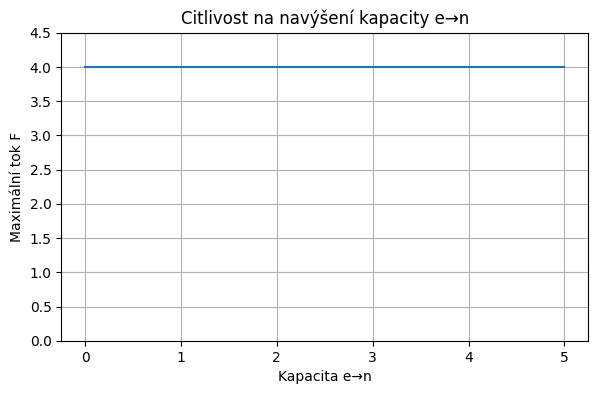

In [10]:
# Graf: optimální tok vs. kapacita e->n
plt.figure(figsize=(6.8,4))
plt.step(df_en["cap"], df_en["F"], where="post")
plt.xlabel("Kapacita e→n")
plt.ylabel("Maximální tok F")
plt.title("Citlivost na navýšení kapacity e→n")
plt.ylim(0, max(df_en["F"])+0.5)
plt.show()


### Změna kapacity `s→a` (posílení zdroje)

In [11]:
grid_sa = np.arange(0, 6, 1)  # 0..5
df_sa = sweep_capacity(("s","a"), grid_sa, caps)
df_sa


edge  cap    F   status
0  s->a    0  2.0  Optimal
1  s->a    1  3.0  Optimal
2  s->a    2  4.0  Optimal
3  s->a    3  4.0  Optimal
4  s->a    4  4.0  Optimal
5  s->a    5  4.0  Optimal

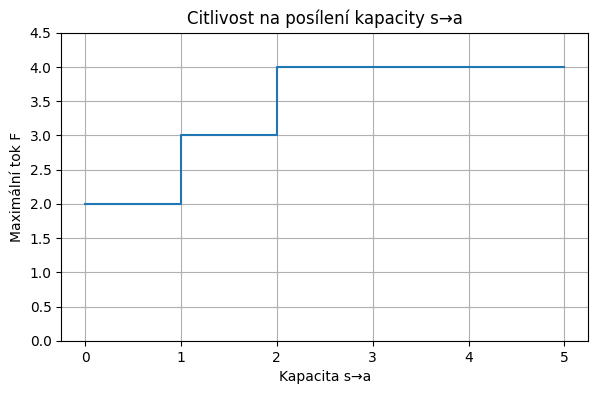

In [12]:
plt.figure(figsize=(6.8,4))
plt.step(df_sa["cap"], df_sa["F"], where="post")
plt.xlabel("Kapacita s→a")
plt.ylabel("Maximální tok F")
plt.title("Citlivost na posílení kapacity s→a")
plt.ylim(0, max(df_sa["F"])+0.5)
plt.show()


# Přidání nové hrany a její kapacita

In [13]:
# Přidáme novou hranu b→d s kapacitou t a zkusíme, kdy se F zvýší
def sweep_new_edge(new_edge, caps_base, t_values):
    rows = []
    for t in t_values:
        caps_new = caps_base.copy()
        caps_new[new_edge] = t
        _, status, Fv, _ = solve_maxflow_lp(nodes, caps_new, "s", "n", msg=False)
        rows.append({
            "cap_new_edge": t,
            "F": Fv,
            "status": status
        })
    return pd.DataFrame(rows)

df_bd = sweep_new_edge(("b","d"), caps, np.arange(0,6,1))
df_bd


cap_new_edge    F   status
0             0  4.0  Optimal
1             1  4.0  Optimal
2             2  4.0  Optimal
3             3  4.0  Optimal
4             4  4.0  Optimal
5             5  4.0  Optimal

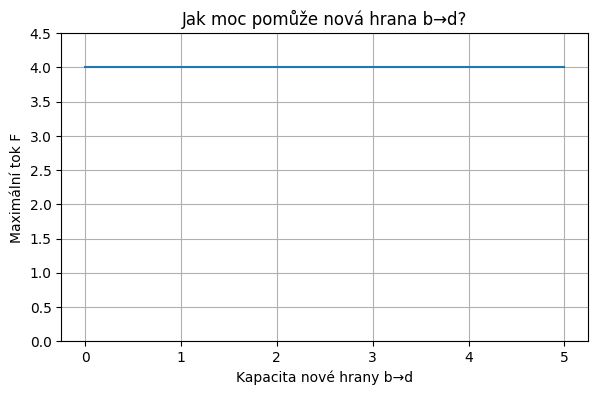

In [14]:
plt.figure(figsize=(6.8,4))
plt.step(df_bd["cap_new_edge"], df_bd["F"], where="post")
plt.xlabel("Kapacita nové hrany b→d")
plt.ylabel("Maximální tok F")
plt.title("Jak moc pomůže nová hrana b→d?")
plt.ylim(0, max(df_bd["F"])+0.5)
plt.show()


### Reálnější scénář

Představme si podnikový WAN: zdroj `S` v datacentru, cíl `T` v cloudu, mezi nimi několik vrstev routerů.
Postavíme **vrstvený graf** se stovkami uzlů a hran s náhodnými kapacitami. Úloha zůstává stejná:
maximalizovat tok z `S` do `T`. Formulace LP je stejná (bilance na uzlech, kapacity na hranách).

Poznámky ke škálování:
- LP model roste s počtem hran `m` (jedna proměnná na hranu) a počtem uzlů `n` (jedna rovnice bilance na uzel).
- Specializované algoritmy pro max‑flow (Dinic, Push‑Relabel) bývají výrazně rychlejší než obecný LP solver.
- Níže ukážeme **obě cesty**: (1) LP v PuLP pro střední problém, (2) specializovaný `networkx.maximum_flow` pro srovnání.


In [18]:
import random, time

def random_layered_undirected(layers=(1, 50, 50, 50, 1), p=0.06, cap_range=(50, 200), seed=7):
    """
    Vytvoří vrstvený graf: v každé dvojici sousedních vrstev přidá náhodné hrany.
    Hrany chápeme jako 'obousměrné jedním směrem' => jedna proměnná s intervalem [-cap, cap].
    """
    rng = random.Random(seed)
    # Vytvoř uzly vrstev
    layer_nodes = []
    count = 0
    for i, k in enumerate(layers):
        L = [f"L{i}_{j}" for j in range(k)]
        layer_nodes.append(L)
    # Přejmenuj zdroj/cíl kvůli kompatibilitě s výše uvedenou funkcí
    layer_nodes[0] = ["S"]
    layer_nodes[-1] = ["T"]
    nodes_big = sum(layer_nodes, [])

    # Hrany jen mezi sousedními vrstvami
    caps_big = {}
    for i in range(len(layer_nodes)-1):
        A = layer_nodes[i]
        B = layer_nodes[i+1]
        for u in A:
            for v in B:
                if rng.random() < p:
                    cap = rng.randint(*cap_range)
                    caps_big[(u,v)] = cap

    return nodes_big, caps_big

# Generuj ~150 uzlů a tisíce hran (upravit dle výkonu Colabu)
nodes_big, caps_big = random_layered_undirected(layers=(1, 40, 40, 40, 1), p=0.08, cap_range=(20, 120), seed=13)
print(f"Uzlů: {len(nodes_big)}, hran: {len(caps_big)}")


Uzlů: 122, hran: 244


In [19]:
# 9a) Řešení velké instance LP (PuLP/CBC) — může trvat desítky vteřin dle velikosti
t0 = time.time()
prob_big, status_big, F_big, flows_big = solve_maxflow_lp(nodes_big, caps_big, source="S", sink="T", msg=False)
t_lp = time.time() - t0
print("LP stav:", status_big)
print(f"LP maximum flow F = {F_big:.1f}, čas {t_lp:.2f} s, proměnných: {len(caps_big)}")

# 9b) Srovnání se specializovaným max-flow (Edmonds-Karp v networkx)
G_dir = nx.DiGraph()
for (u,v), cap in caps_big.items():
    # Add both directions with the same capacity, since LP allows negative x_uv
    G_dir.add_edge(u, v, capacity=cap)
    G_dir.add_edge(v, u, capacity=cap)

t0 = time.time()
val_nx, flow_dict = nx.maximum_flow(G_dir, "S", "T", flow_func=nx.algorithms.flow.edmonds_karp)
t_nx = time.time() - t0
print(f"networkx maximum_flow = {val_nx:.1f}, čas {t_nx:.2f} s, hran: {G_dir.number_of_edges()}")


LP stav: Optimal
LP maximum flow F = 33.0, čas 0.02 s, proměnných: 244
networkx maximum_flow = 33.0, čas 0.00 s, hran: 488


Výřez: uzlů 62, hran 117, status = Optimal, F = 33.0


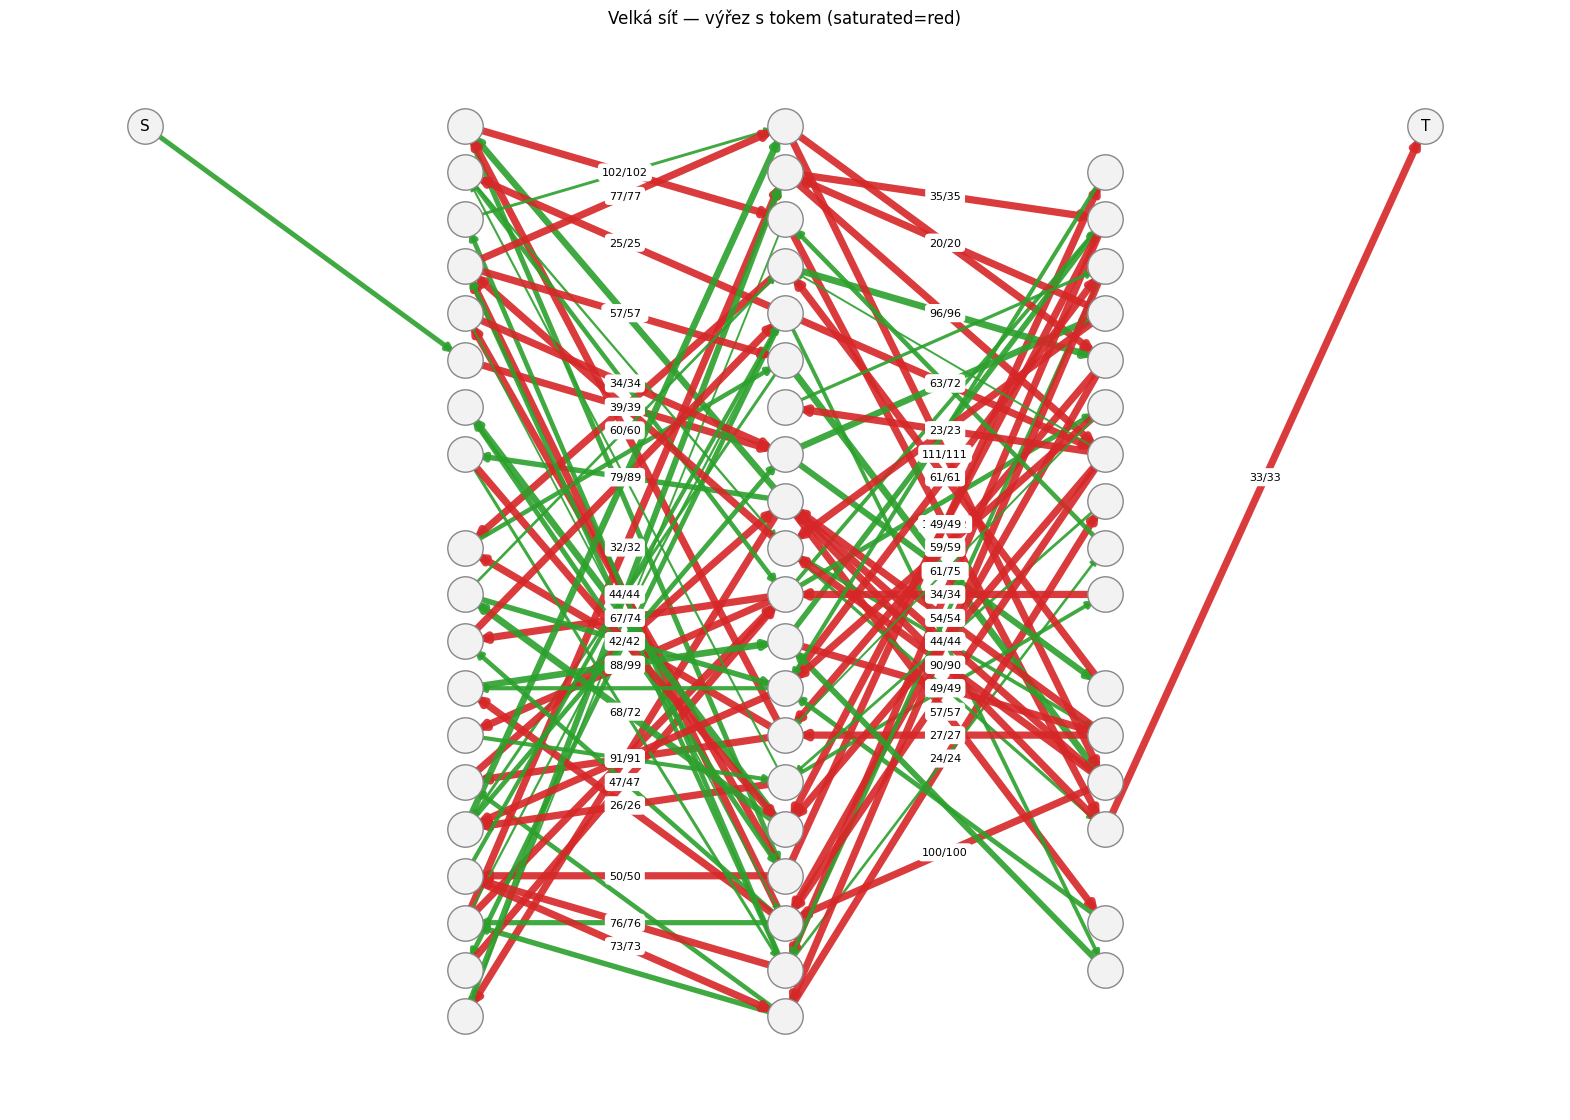

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# --- Subgraph with guaranteed S→T path ---
def subgraph_topk_per_layer_connected(nodes, caps, k_start=6, k_max=20):
    layers = {}
    deg = {n:0 for n in nodes}
    for (u,v) in caps:
        deg[u] = deg.get(u,0)+1
        deg[v] = deg.get(v,0)+1
        L  = u.split("_")[0] if u not in ("S","T") else u
        L2 = v.split("_")[0] if v not in ("S","T") else v
        layers.setdefault(L, set()).add(u)
        layers.setdefault(L2, set()).add(v)

    nodes_sub, caps_sub = [], {}
    for k in range(k_start, k_max+1):
        keep = {"S","T"}
        for L, lst in layers.items():
            if L in ("S","T"):
                continue
            sel = sorted(lst, key=lambda x: (-deg.get(x,0), x))[:k]
            keep.update(sel)
        caps_sub = {e:c for e,c in caps.items() if e[0] in keep and e[1] in keep}
        nodes_sub = sorted(keep)

        G = nx.DiGraph()
        G.add_nodes_from(nodes_sub)
        for (u,v),cap in caps_sub.items():
            G.add_edge(u,v,capacity=cap)
        if nx.has_path(G, "S", "T"):
            break
    return nodes_sub, caps_sub

# --- Layered layout that adapts to any number of layers ---
def layered_pos(nodes):
    levels = {}
    max_lvl = max([int(n.split("_")[0][1:]) for n in nodes if n not in ("S","T")], default=1)
    for n in nodes:
        if n == "S": levels[n] = 0
        elif n == "T": levels[n] = max_lvl + 1
        else: levels[n] = int(n.split("_")[0][1:])
    xs = {n: levels[n] for n in nodes}
    ys = {}
    for lvl in sorted(set(levels.values())):
        row = [n for n in nodes if levels[n] == lvl]
        # deterministic vertical spacing
        for i, n in enumerate(sorted(row)):
            ys[n] = -i
    return {n: (xs[n], ys[n]) for n in nodes}

# --- Build digraph oriented by actual flows (only edges with |flow| > tol) ---
def build_flow_digraph(caps, flows, flow_tol=1e-9):
    G = nx.DiGraph()
    for (u,v), cap in caps.items():
        val = flows[(u,v)]
        if abs(val) <= flow_tol:
            continue
        if val >= 0:
            G.add_edge(u, v, flow=float(val), cap=float(cap))
        else:
            G.add_edge(v, u, flow=float(-val), cap=float(cap))
    # mark saturation
    for u, v, data in G.edges(data=True):
        data["sat"] = abs(data["flow"] - data["cap"]) <= 1e-9
        data["util"] = data["flow"] / max(1.0, data["cap"])
    return G

# --- Clean drawing: only S/T labels, edge labels only if saturated or above threshold ---
def draw_flow_clean(G, pos, title="", label_threshold=0.75):
    fig, ax = plt.subplots(figsize=(20, 14))
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=650, node_color="#f2f2f2", edgecolors="#888", ax=ax)
    nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if n in ("S","T")}, font_size=11, ax=ax)

    # edges
    widths = [1.2 + 4.0*data["util"] for _,_,data in G.edges(data=True)]
    colors = ["#d62728" if data["sat"] else "#2ca02c" for _,_,data in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=widths, edge_color=colors, arrows=True, arrowstyle="-|>", alpha=0.9, ax=ax)

    # edge labels: saturated or high utilization
    edge_labels = {}
    for u,v,data in G.edges(data=True):
        if data["sat"] or data["util"] >= label_threshold:
            edge_labels[(u,v)] = f'{data["flow"]:.0f}/{int(data["cap"])}'
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, rotate=False, ax=ax)

    ax.set_title(title)
    ax.set_axis_off()
    plt.show()

# ==== Usage with your existing solve ====
nodes_sub, caps_sub = subgraph_topk_per_layer_connected(nodes_big, caps_big, k_start=6, k_max=20)
_, status_sub, F_sub, flows_sub = solve_maxflow_lp(nodes_sub, caps_sub, "S", "T", msg=False)
print(f"Výřez: uzlů {len(nodes_sub)}, hran {len(caps_sub)}, status = {status_sub}, F = {F_sub:.1f}")

pos_large = layered_pos(nodes_sub)
G_vis = build_flow_digraph(caps_sub, flows_sub)
draw_flow_clean(G_vis, pos_large, title="Velká síť — výřez s tokem (saturated=red)", label_threshold=0.80)


**Závěr k velké instanci.**  
LP přístup je univerzální a transparentní, dobře se ladí s dalšími omezeními (politiky směrování, náklady, logické podmínky).
Pro čistý „max‑flow“ však specializované algoritmy obvykle vyhrají časem i pamětí.
Pro výuku lineárního programování je ale LP formulace ideální: stejný vzor funguje na malých i velkých sítích.
